#Reference 
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
import pandas as pd
df = pd.read_csv('consumer_complaints_small.csv')
df.head()

,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,Consumer Loan,Due to inconsistencies in the amount owed that...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,Mortgage,I have an open and current mortgage with Chase...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [2]:
from io import StringIO
col = ['product', 'consumer_complaint_narrative']
df = df[col]
df = df[pd.notnull(df['consumer_complaint_narrative'])]
df.columns = ['product', 'consumer_complaint_narrative']
df['category_id'] = df['product'].factorize()[0]
category_id_df = df[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
df.head()

,product,consumer_complaint_narrative,category_id
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
1,Consumer Loan,Due to inconsistencies in the amount owed that...,1
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
3,Mortgage,I have an open and current mortgage with Chase...,2
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

df.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#features = tfidf.fit_transform(df.consumer_complaint_narrative).toarray()

features = tfidf.fit_transform(df.consumer_complaint_narrative)

labels = df.category_id
features.shape

(66806, 159200)

In [5]:
#We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:

In [6]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for Product, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(Product))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [7]:
# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['consumer_complaint_narrative'], df['product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
# After fitting the training set, let’s make some predictions.

In [10]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [11]:
df[df['consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,product,consumer_complaint_narrative,category_id


In [12]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [13]:
df[df['consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,product,consumer_complaint_narrative,category_id


## Model Selection
### We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.
### We will benchmark the following four models:
### Logistic Regression
### (Multinomial) Naive Bayes
### Linear Support Vector Machine
### Random Forest

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


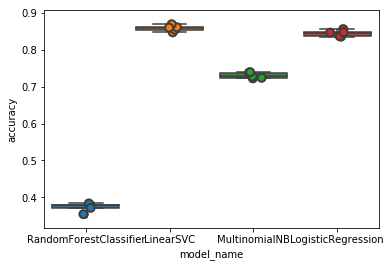

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


models = [
     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
     LinearSVC(),
     MultinomialNB(),
     LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.858457
LogisticRegression        0.844566
MultinomialNB             0.730370
RandomForestClassifier    0.373322
Name: accuracy, dtype: float64

# Model Evaluation
# Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

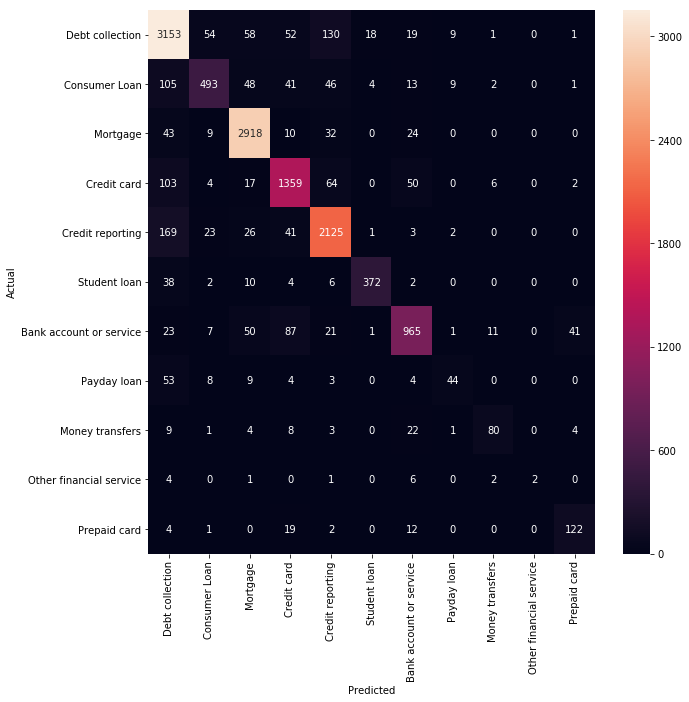

In [37]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [38]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['product', 'consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Debt collection' : 105 examples.


,product,consumer_complaint_narrative
1687,Consumer Loan,I am being harassed by a company called http X...
66273,Consumer Loan,I have been contacted multiple times via Phone...
52131,Consumer Loan,"account has been closed and no amount is due, ..."
20743,Consumer Loan,Received un unsigned letter from Ford Credit i...
46173,Consumer Loan,I received a loan from world finance and and l...
14936,Consumer Loan,my car was repossedOn XXXX XXXX 2015 you recei...
49717,Consumer Loan,I was paying on a collections that was on my c...
59650,Consumer Loan,I have submitted a cease and desist letter to ...
737,Consumer Loan,In XX/XX/XXXX I was mailed a check and paperwo...
8774,Consumer Loan,I became ill in a few years ago and had to tak...



'Mortgage' predicted as 'Debt collection' : 43 examples.


,product,consumer_complaint_narrative
27463,Mortgage,Upon trying to setup my account information af...
35670,Mortgage,Civil Theft of a Note \n
8177,Mortgage,I received a phone call today from a man at ar...
46435,Mortgage,I filed bankruptcy ( case XXXX ) XXXX Californ...
41662,Mortgage,FAIR COLLECTIONS AND OUTSOURSING has placed er...
51005,Mortgage,"The company in question ( DiTech, formally Gre..."
25753,Mortgage,I owned a property that was foreclosed and I n...
25087,Mortgage,hardship loss job have not been able to recove...
62781,Mortgage,I found a foreclosure that never happened. I f...
56900,Mortgage,our mortgage was sold to a different company. ...



'Credit card' predicted as 'Debt collection' : 103 examples.


,product,consumer_complaint_narrative
4800,Credit card,For a medical service my wife made an advance ...
53120,Credit card,NETCREDIT made false statements to cfpb. I sus...
56712,Credit card,TJmaxx Reward/Synchrony. and or their collecti...
46585,Credit card,"we have learned the debt collector, XXXX XXXX,..."
31283,Credit card,On XXXX/XXXX/15 I received a phone message fro...
38732,Credit card,A man named XXXX XXXX called my new husband tr...
1610,Credit card,The company denied my dispute of XXXX XXXX cha...
4780,Credit card,We had fraud in our office and money was stole...
42285,Credit card,I contacted XXXX about a couple months ago and...
52700,Credit card,I wish to have your assistance in disputing XX...



'Credit reporting' predicted as 'Debt collection' : 169 examples.


,product,consumer_complaint_narrative
15366,Credit reporting,Any and all medical bills reported by any agen...
3603,Credit reporting,I have informed XXXX XXXX many time that XXXX ...
8142,Credit reporting,the XXXX bureaus have falsified my credit rati...
16790,Credit reporting,We moved in XXXX of 2014 to XXXX from XXXX. XX...
17753,Credit reporting,At the time of this visit to the hospital I wa...
30113,Credit reporting,I checked my credit report and noticed that th...
20451,Credit reporting,XXXX {$320.00} was paid and clearedConfirmatio...
17038,Credit reporting,I have paid off the debt to Procollect on XXXX...
25890,Credit reporting,XXXX XXXX is a collection agency attempting to...
66710,Credit reporting,The debt is not mine because I am and was not ...



'Student loan' predicted as 'Debt collection' : 38 examples.


,product,consumer_complaint_narrative
58434,Student loan,COLLECTION NOTICE SENT TO MY DECEASED MOTHER I...
30855,Student loan,Questionable debt collecting agency XXXX Sunri...
12226,Student loan,Pioneer credit recovery has been harassing me ...
17802,Student loan,AES/NCT/XXXX have multiple credit marks on my ...
6366,Student loan,I was contacted by American Education Services...
63871,Student loan,Due to unemployment was unable to continue wit...
29846,Student loan,Trumped up my principal owed illegally. \n
41798,Student loan,I borrowed from XXXX towards my XXXX education...
62501,Student loan,Co-signer of loan not notified of non payment ...
20440,Student loan,I am not sure if my loan is federal or private...



'Bank account or service' predicted as 'Debt collection' : 23 examples.


,product,consumer_complaint_narrative
42907,Bank account or service,Santander bank is constantly calling and leavi...
9961,Bank account or service,My elderly parents were sold a trust from Well...
40734,Bank account or service,Bank of America has been trying to collect on ...
2287,Bank account or service,I had an account for an IRA with a company. Th...
30183,Bank account or service,Hi my Name is XXXX XXXX I received a call from...
11746,Bank account or service,""" Google XXXX XXXX '' calls XXXX or XXXX times..."
8309,Bank account or service,We finance a bed bought at XXXX in XXXX 2014. ...
41173,Bank account or service,There is an account with Pioneer/XXXX XXXX XXX...
61458,Bank account or service,Citibank decided on their own not to send me m...
29996,Bank account or service,This is in reference to company call Direct Ex...



'Payday loan' predicted as 'Debt collection' : 53 examples.


,product,consumer_complaint_narrative
64282,Payday loan,I was never contacted by the lender. Not even ...
8195,Payday loan,I have ask Ad Astra Recovery Account XXXX on a...
54418,Payday loan,XXXX ID : XXXX CASE FILE # : NT - XXXX LOAN IN...
12206,Payday loan,A outside collection agency told me to make a ...
1212,Payday loan,A third party collection agency is calling my ...
58422,Payday loan,I received a settlement letter from Ad Astra R...
857,Payday loan,My balance was under {$50.00} and they added c...
50810,Payday loan,They have called me 38 times since XXXX XXXX. ...
36355,Payday loan,My coworker received a call from High Point As...
59048,Payday loan,CBE Group has never sent me a letter in the ma...



'Debt collection' predicted as 'Consumer Loan' : 54 examples.


,product,consumer_complaint_narrative
2040,Debt collection,I had recently made settlement arrangements wi...
50574,Debt collection,"I, ve contacted Lobel Financial about this deb..."
2717,Debt collection,On XXXX at XXXX spoke to a rep at XXXX financi...
30029,Debt collection,"I am behind on paying the loan, and take full ..."
43653,Debt collection,Had a car repo in ( i think 2007 ) drive time ...
44485,Debt collection,Loan Insurance Fee Scams ( XXXX ) Companies : ...
53854,Debt collection,Springleaf Financial is another one that start...
7191,Debt collection,"I recently had repossession of my vehicle, The..."
926,Debt collection,XXXX has listed on my credit report a debt tha...
27675,Debt collection,Took out an auto loan/truck repossessed in 200...



'Credit reporting' predicted as 'Consumer Loan' : 23 examples.


,product,consumer_complaint_narrative
21141,Credit reporting,THERE WAS INQUIRES ON MY CREDIT REPORT THAT I ...
52301,Credit reporting,Our car was totalled after we were hit by anot...
55417,Credit reporting,I purchased a a car from XXXX XXXX. in XXXX. I...
14894,Credit reporting,I traded in 2013 XXXX XXXX that was financed w...
39867,Credit reporting,"I have contacted Capital One Auto Finance, sev..."
1648,Credit reporting,An car loan that supposedly was taken out on X...
66252,Credit reporting,On XXXX/XXXX/XXXX I went into XXXX XXXX of XXX...
14684,Credit reporting,My issue is with a car lease. The car was not ...
6838,Credit reporting,My complaint involves XXXX XXXX XXXX in XXXX. ...
789,Credit reporting,In XXXX I purchased a vehicle and became ill r...



'Debt collection' predicted as 'Mortgage' : 58 examples.


,product,consumer_complaint_narrative
10906,Debt collection,Since XXXX XXXX XXXX XXXX ( Under Lender Live ...
47455,Debt collection,Bank of America. {$36000.00}. \nRequest : Dele...
13738,Debt collection,PNC Mortgage is not allowing a short sale to p...
49226,Debt collection,I have several medical bills that I am trying ...
31057,Debt collection,I recorded some of the conversations with them...
26603,Debt collection,When the economy turned bad XX/XX/XXXX and wor...
41766,Debt collection,We received a letter from Select Portfolio Ser...
38919,Debt collection,I became XXXX with XXXX in XXXX. I received a ...
49587,Debt collection,In XXXX I lost my home to foreclosure. There w...
57658,Debt collection,"On XX/XX/XXXX, I received ( XXXX ) Letters fro..."



'Consumer Loan' predicted as 'Mortgage' : 48 examples.


,product,consumer_complaint_narrative
65944,Consumer Loan,"Aqua finance, financial systems of greenbay an..."
53531,Consumer Loan,"I received a late fee in XXXX 2015, which was ..."
16563,Consumer Loan,"In XX/XX/XXXX, we took out a land loan from M ..."
41670,Consumer Loan,Issue : Breach of Written Settlement Agreement...
24381,Consumer Loan,the lender was very good at giving the loan ou...
12530,Consumer Loan,I took out a CitiFinancial XXXX loan in XXXX. ...
34228,Consumer Loan,"When i first established this loan, i requeste..."
12296,Consumer Loan,I called Wells Fargo to report a lost credit c...
11396,Consumer Loan,Forced to take predatory loan right after XXXX...
63128,Consumer Loan,XX/XX/2016 I was researching for a good option...



'Credit card' predicted as 'Mortgage' : 17 examples.


,product,consumer_complaint_narrative
9408,Credit card,-- -- -- -- -- Forwarded message -- -- -- -- -...
42262,Credit card,We are trying to resolve an issue with Chase a...
54957,Credit card,"We are XXXX citizens, and my husband made a pa..."
59483,Credit card,THEIR WEBSITE IS NOT WORKING \n
48358,Credit card,"On XXXX XXXX, 2015 my bank sent out a check to..."
46914,Credit card,I have banked with Suntrust for almost 20 year...
61690,Credit card,The account was cancelled due to past due on a...
57527,Credit card,A company hired to help us raise our credit sc...
33264,Credit card,Capitaol One bank USA shows a 30 day late in X...
45714,Credit card,"On XXXX XXXX, 2015, I received a letter from C..."



'Credit reporting' predicted as 'Mortgage' : 26 examples.


,product,consumer_complaint_narrative
42284,Credit reporting,I had home located at XXXX XXXX XXXX XXXX XXXX...
23935,Credit reporting,My first and second mortgage was through XXXX ...
66797,Credit reporting,Banks tell me I have home morgages open when I...
23936,Credit reporting,My first and second mortgage was through XXXX ...
18773,Credit reporting,XXXX XXXX XXXX is incorrectly reporting on my ...
28359,Credit reporting,Several disputes have been sent in regarding m...
60268,Credit reporting,Wells Fargo Bank is reporting a foreclosure on...
60445,Credit reporting,TD Bank XXXX XXXX XXXX Bank NA ) REFUSED to pr...
51011,Credit reporting,I was in a chapter XXXX. The mortgage company ...
47879,Credit reporting,I have supplied the credit reporting Agency do...



'Student loan' predicted as 'Mortgage' : 10 examples.


,product,consumer_complaint_narrative
5973,Student loan,I signed an agreement to payoff my Citi studen...
58621,Student loan,Force-able collections and predatory lending. ...
46255,Student loan,Forberance period expended. Tried to request f...
27269,Student loan,"In preparation for a mortgage, I requested a s..."
43636,Student loan,"XX/XX/XXXX, my payment was lost. When I called..."
26246,Student loan,I XXXX XXXX co-sign load for my son XXXX XXXX....
39075,Student loan,I received a loan from XXXX to take the NY XXX...
14558,Student loan,An application was submitted to remove the co-...
37407,Student loan,Chase and XXXX will not provide my full paymen...
47432,Student loan,"My interest rate went up, when I was supposed ..."



'Bank account or service' predicted as 'Mortgage' : 50 examples.


,product,consumer_complaint_narrative
54647,Bank account or service,Morgan Stanley mis-reported our XXXX XXXX cont...
18373,Bank account or service,"Hello to whom this may concern, My name is XXX..."
8575,Bank account or service,On or around XXXX/XXXX/2015 I realized I owed ...
17607,Bank account or service,I made several attains to pay my bill via Navy...
28423,Bank account or service,My guest trailer/camper burned down XXXX 2014....
41887,Bank account or service,I made few claims and Wells Fargo approved the...
32434,Bank account or service,"My home was damaged by fire in XXXX 2013, a cl..."
54537,Bank account or service,Spam mail to our mailbox with information we d...
25215,Bank account or service,Homeowner filed a claim with his insurance com...
36140,Bank account or service,"I lodged the below complaint with Wells fargo,..."



'Debt collection' predicted as 'Credit card' : 52 examples.


,product,consumer_complaint_narrative
16202,Debt collection,The company FIA card services which is a subsi...
9285,Debt collection,I got a bill amount of {$63.00} from XXXX on X...
48311,Debt collection,After several back and forth with chase about ...
61754,Debt collection,I HAD DISCOVER CREDIT CARD I MISSED FEW PAYMEN...
60841,Debt collection,"received a statement from XXXX XXXX , XXXX sta..."
24358,Debt collection,TDBAnk/ Target refused to accept credit counse...
66763,Debt collection,I was 6 months late with XXXX Wells Fargo cred...
1606,Debt collection,i do not recognize this information this is a ...
33528,Debt collection,I do n't even know where to start. I 've done ...
17259,Debt collection,I request a dispute with dtv XXXX service with...



'Consumer Loan' predicted as 'Credit card' : 41 examples.


,product,consumer_complaint_narrative
14786,Consumer Loan,RE : Capital One ( Secured Credit Card ) Accou...
37058,Consumer Loan,"Chase Finance is charging a {$10.00} "" return ..."
47918,Consumer Loan,I called and emailed Wells Fargo Several times...
65492,Consumer Loan,I 'm being charged a balance of {$190.00} by C...
21742,Consumer Loan,This was a 0 interest loan for 36 months. If n...
64968,Consumer Loan,I did a pay off of {$9000.00} on Lending Club ...
64636,Consumer Loan,I made an on line purchase of a class ring in ...
11843,Consumer Loan,I somehow got multiple paypal accounts with XX...
19364,Consumer Loan,I purchased a washer and dryer from XXXX. XXXX...
10758,Consumer Loan,I went to a local Sun Loans branch to pay of a...



'Mortgage' predicted as 'Credit card' : 10 examples.


,product,consumer_complaint_narrative
49654,Mortgage,XXXX I had to file a personal bankruptcy ( due...
54682,Mortgage,I setup a payment online as I made previous pa...
9560,Mortgage,I have already written to you to dispute with ...
29359,Mortgage,"I am a widow, unemployed and XXXX. My husband ..."
60301,Mortgage,I made XXXX payments in XXXX XXXX for {$7.00} ...
18754,Mortgage,I had an issue last year where hail damaged oc...
57968,Mortgage,XXXX NMLS # XXXX charged our credit card {$450...
58196,Mortgage,Filled a complaint on XXXX/XXXX/2015 ( XXXX ) ...
53157,Mortgage,I opened a line of credit with US Bank in XXXX...
9341,Mortgage,Bank of America charging me for late payments ...



'Credit reporting' predicted as 'Credit card' : 41 examples.


,product,consumer_complaint_narrative
24691,Credit reporting,There 's XXXX credit card record. \nI have onl...
51970,Credit reporting,I opened a new credit account with XXXX XXXX X...
37925,Credit reporting,why should I have to write a letter to get my ...
44634,Credit reporting,Look. I am trying to get a credit card? All I ...
24126,Credit reporting,I applied for a credit card and was denied ( s...
13578,Credit reporting,"My XXXX credit card account has been paid off,..."
19902,Credit reporting,XXXX allowed a 3rd party to charge to my accou...
34463,Credit reporting,XXXX cable charged my account with incorrect c...
29005,Credit reporting,A new employer has been added but I am both XX...
9773,Credit reporting,1. at this time. home depot is paid in full. i...



'Bank account or service' predicted as 'Credit card' : 87 examples.


,product,consumer_complaint_narrative
60650,Bank account or service,"I went to the citibank branch at XXXX XXXX in,..."
46982,Bank account or service,I had money debited out of my wells fargo acco...
4834,Bank account or service,I inquired specifically regarding the ability ...
46900,Bank account or service,I applied for a Premier Line of Credit with US...
40383,Bank account or service,Synchrony Bank/JCP ; Has presumed that I owe t...
62053,Bank account or service,I elected to start using PayPal for most of my...
19767,Bank account or service,Charged off accountDue to a bank error \n
57675,Bank account or service,amazon store card was charged for about XXXX d...
7768,Bank account or service,I contacted USAA bank to dispute a charge afte...
14246,Bank account or service,My husband took out a no interest for 12 month...



'Prepaid card' predicted as 'Credit card' : 19 examples.


,product,consumer_complaint_narrative
57271,Prepaid card,My check is directly deposited weekly on my ca...
18901,Prepaid card,XX/XX/XXXX I had used pay pal to purchase an i...
40194,Prepaid card,I had earned a visa rewards card from a credit...
59220,Prepaid card,Hello - I am a American express credit card me...
19395,Prepaid card,I purchased XXXX XXXX gift cards of $ XXXX/eac...
2778,Prepaid card,There were XXXX unauthorized transactions on m...
42402,Prepaid card,I purchased a Blue Bird AMerican Express card ...
45933,Prepaid card,"When I bought my XXXX phone, the app American ..."
41916,Prepaid card,I had a US Bank Visa gift card that was obviou...
25498,Prepaid card,Dear American Express Representative or To Who...



'Debt collection' predicted as 'Credit reporting' : 130 examples.


,product,consumer_complaint_narrative
2260,Debt collection,NATIOSTAR MORTAGE IS REPORTING FORECLOSURE AND...
38136,Debt collection,i have attempted to take care of this matter w...
39670,Debt collection,this was recently submitted to you through thi...
3580,Debt collection,CBCINNOVIS reported my XXXX year old Father 's...
20768,Debt collection,I never had a XXXX phone \n
65960,Debt collection,UNITED REVENUE CORPORATION IS REPORTING XXXX A...
11811,Debt collection,These are over 7 years old by my ex and they k...
35408,Debt collection,", i have never lived on XXXX XXXX, i have live..."
38476,Debt collection,Still on credit report as delinquent. Please h...
21847,Debt collection,"After the past several years of XXXX, starting..."



'Consumer Loan' predicted as 'Credit reporting' : 46 examples.


,product,consumer_complaint_narrative
23679,Consumer Loan,I feel that I 'm paying more than I should. \n
19996,Consumer Loan,"In XXXX, my husband lost his job and I had to ..."
40780,Consumer Loan,After i was unable to pay because of job loss ...
44958,Consumer Loan,I had XXXX conn 's accounts opened in XX/XX/XX...
61907,Consumer Loan,Upon reviewing a XXXX XXXX credit report pulle...
42020,Consumer Loan,I have been on the opt-out prescreen list for ...
8127,Consumer Loan,Trying to get a loan and found a misc. mark on...
48490,Consumer Loan,Inaccurate information is being reported to XX...
20749,Consumer Loan,Santander Bank Incorrectly stated late by thir...
51680,Consumer Loan,My Name : XXXX XXXX Mailing Address : XXXX XXX...



'Mortgage' predicted as 'Credit reporting' : 32 examples.


,product,consumer_complaint_narrative
28826,Mortgage,I have XXXX hard inquiries from Safe Rent ( XX...
10419,Mortgage,Ocwen Loan has reported several different acco...
49053,Mortgage,B of A is showing a home equity line of credit...
4725,Mortgage,"Incorrect plaintiff foreclosed on me, forcing ..."
52660,Mortgage,I was fully expecting to submit a dispute that...
16181,Mortgage,I asked for my documenation I asked for it num...
39061,Mortgage,transunion credit bureau has me at a very low ...
55872,Mortgage,To : SPS and Equifax XXXX/XXXX/2016 From XXXX ...
64829,Mortgage,I have already submitted a complaint # XXXX. I...
60700,Mortgage,This complaint is in reference to case numbers...



'Credit card' predicted as 'Credit reporting' : 64 examples.


,product,consumer_complaint_narrative
8628,Credit card,I have spoken to Bank of American concerning t...
20674,Credit card,Fradulent credit inquiry on my credit report. ...
15089,Credit card,Over the last several months after seeing a ne...
9709,Credit card,I was turned down for credit by XXXX c/c compa...
34256,Credit card,Trade line was removed from my credit reportin...
60420,Credit card,I found out Pay Pal Credit ; or XXXX/PPC as it...
40896,Credit card,"Capitol One reported to XXXX, XXXX and XXXX th..."
58074,Credit card,My ex-wife made me an authorized user on her c...
2988,Credit card,I WAS TRYING TO BUY A NEW CAR AND THE CAR DEAL...
53544,Credit card,hello i applied for XXXX card with this bank a...



'Bank account or service' predicted as 'Credit reporting' : 21 examples.


,product,consumer_complaint_narrative
61766,Bank account or service,I received several errors and miss matched inf...
14010,Bank account or service,My mother put me as a user for XXXX of her cre...
16284,Bank account or service,Navy Federal Credit Unionsays I owe them money...
54374,Bank account or service,I opened a XXXX account and when I tried to us...
51655,Bank account or service,I went to sign up for a PayPal account and lat...
52931,Bank account or service,Was trying to cash a small check and was denie...
156,Bank account or service,In my report is u.s.bank which I never used an...
63019,Bank account or service,Identity theft. Someone opened up XXXX XXXX XX...
27566,Bank account or service,Your form is malfunctioning. See attached desc...
53902,Bank account or service,XXXX charged my account {$12.00} even after I ...



'Debt collection' predicted as 'Student loan' : 18 examples.


,product,consumer_complaint_narrative
43642,Debt collection,"For the last few weeks, we have gotten numerou..."
18654,Debt collection,I advised in the conversation with the represe...
61580,Debt collection,As a cosigner for my children the Credit repor...
17967,Debt collection,Collection Agency stated that I attended XXXX ...
64055,Debt collection,This complaint involves unlawful third-party c...
49439,Debt collection,Wells Fargo Bank uses an automated phone syste...
39986,Debt collection,Attorney firm filed a civil action suit agains...
58109,Debt collection,XXXX University under the XXXX XXXX umbrella s...
832,Debt collection,Navient calls between XXXX times every single ...
54758,Debt collection,There was a lawsuit against the school that I ...



'Debt collection' predicted as 'Bank account or service' : 19 examples.


,product,consumer_complaint_narrative
22991,Debt collection,"Ally bank continues to call my cell phone, aft..."
1041,Debt collection,The office manager charged me {$35.00} for not...
15682,Debt collection,XX/XX/2015 I filed a chargeback with Chase ban...
46756,Debt collection,I made arrangement with Chase Bank to make mon...
7685,Debt collection,XXXX I get a letter from an attorney saing or ...
30164,Debt collection,Bank of America is reporting my old account as...
62016,Debt collection,"About 3 years ago, I started my own XXXX and o..."
65197,Debt collection,"On XXXX XXXX, XXXX, I terminated my checking a..."
24251,Debt collection,In regard to the EFTA ( Electronic Funds Trans...
11275,Debt collection,i paid the card off the bank froze the account...



'Consumer Loan' predicted as 'Bank account or service' : 13 examples.


,product,consumer_complaint_narrative
41597,Consumer Loan,I called 5th 3rd bank to see if I was included...
53155,Consumer Loan,"XX/XX/XXXX or XX/XX/2015, I referred my mother..."
9561,Consumer Loan,XXXX/XXXX/2015 QCS ITEMFEE CK RETURN FEE ID XX...
25216,Consumer Loan,I have a loans out through XXXX. I have had fr...
9054,Consumer Loan,"As a Wells Fargo checking, savings and auto lo..."
3398,Consumer Loan,"In early XXXX 2015, I entered Compass Bank to ..."
40855,Consumer Loan,You have Ally bank listed twice on XXXX/XXXX/2...
7251,Consumer Loan,"Good Night, My name is XXXX XXXX. I am financi..."
5033,Consumer Loan,my complaint is against BBT the bank I have a ...
11625,Consumer Loan,Citizens One reversed a payment from my loan s...



'Mortgage' predicted as 'Bank account or service' : 24 examples.


,product,consumer_complaint_narrative
64092,Mortgage,My issues with Citizens Bank are numerous. ( 1...
50821,Mortgage,I was intentionally lied to about payoff amoun...
66240,Mortgage,USAA has sent me a check due to overpayment of...
16970,Mortgage,Citizens Bank held a Boat mortgage for about 1...
13178,Mortgage,"On Wednesday, XX/XX/2015, I went to my local S..."
47043,Mortgage,TD bank keeps reporting me for the past 2 year...
6125,Mortgage,hi my name is XXXX XXXX I 'm running about Td ...
56442,Mortgage,2 years ago I went into a payment program when...
22548,Mortgage,I paid off my equity loan and ask the bank emp...
14921,Mortgage,this is a continuation of complaint XXXX banks...



'Credit card' predicted as 'Bank account or service' : 50 examples.


,product,consumer_complaint_narrative
10290,Credit card,During a dispute of the type of fee charged to...
9816,Credit card,Bank of America was sending my statements to s...
28947,Credit card,XXXX/XXXX/XXXXDear CFPB : Chase Visa defrauds ...
64664,Credit card,US Bank recently cancelled the free night awar...
50180,Credit card,I 've had a FIA XXXX Credit Card since XXXX. I...
51979,Credit card,There were several items that were never dlive...
48727,Credit card,For years I had credit limits over XXXX. Then ...
24701,Credit card,My debit card was stolen when I was at a XXXX ...
39104,Credit card,On XX/XX/2014 someone forge my name for {$1000...
1191,Credit card,"My name is XXXX XXXX XXXX, I live at XXXX XXXX..."



'Money transfers' predicted as 'Bank account or service' : 22 examples.


,product,consumer_complaint_narrative
33702,Money transfers,Requested subpoenaed records from Bank of Amer...
30351,Money transfers,I transferred XXXX USD through JPM CHASE on XX...
4461,Money transfers,I made a wire transfer through Citibank to XXX...
58953,Money transfers,I have got scamed this person called me on the...
49958,Money transfers,"As an ebay XXXX, I have been dealing with rece..."
14158,Money transfers,On XX/XX/XXXX I responded to a XXXX vacation r...
6082,Money transfers,"Paypal submitted a credit check on myself, wit..."
37272,Money transfers,"On XXXX, XXXX, and finally on XXXX I attempted..."
40553,Money transfers,"On XXXX XXXX, 2015, I received an email from a..."
43794,Money transfers,HSBC Bank N.A Is always confiscating money tra...



'Prepaid card' predicted as 'Bank account or service' : 12 examples.


,product,consumer_complaint_narrative
54549,Prepaid card,ADP TotalPay card with money network upgraded ...
56982,Prepaid card,My account was froze for 5 days. I could not a...
19880,Prepaid card,Redeemed a promotion through XXXX XXXX. I rece...
6555,Prepaid card,My paypal account was permanently limited on X...
57114,Prepaid card,SINCE XXXX XXXX EST XXXX XXXX Rush card custom...
2392,Prepaid card,Experienced identity theft fraud involving my ...
62827,Prepaid card,"I received a notice dated XXXX XXXX, 2015 stat..."
35006,Prepaid card,I opened an American Express Bluebird account ...
41179,Prepaid card,I purchased visa gift card labeled as debit fr...
27729,Prepaid card,XXXX XXXX Services froze my XXXX computer scre...



'Bank account or service' predicted as 'Money transfers' : 11 examples.


,product,consumer_complaint_narrative
66757,Bank account or service,"On XXXX XXXX, 2016, I initiated a "" Send Money..."
1963,Bank account or service,Bank is unable to retrieve transfer that was d...
34432,Bank account or service,! I was scammed out of {$8900.00} of my hard e...
22550,Bank account or service,I was trying to send remittance ( amount of {$...
4226,Bank account or service,I did accept a transfer service that was offer...
18296,Bank account or service,Because of a lawsuit that my partner and I hav...
14061,Bank account or service,recd text from XXXXXXXXXXXX \n
66758,Bank account or service,I paid via Paypal a friend for a game currency...
33806,Bank account or service,"Dear sir or madam, This is regarding my XXXX P..."
11476,Bank account or service,I wired money on XXXX/XXXX/2015 from USAA acco...



'Bank account or service' predicted as 'Prepaid card' : 41 examples.


,product,consumer_complaint_narrative
57377,Bank account or service,XXXX XXXX co founder of Rush card has been sec...
64516,Bank account or service,"Today, XXXX/XXXX/16, I received a XXXX XXXX ca..."
40875,Bank account or service,This is the second time my card with comerca b...
56489,Bank account or service,on XXXX XXXX XXXX I called rushcard to say my ...
57286,Bank account or service,"On XXXX/XXXX/2015, Rushcard scheduled system m..."
59132,Bank account or service,Rush card has completely been so disrespectful...
57130,Bank account or service,Rush Card did routine maintenance to a new ser...
58076,Bank account or service,On XXXX XXXX 2015 I cash a check with the comp...
56628,Bank account or service,I have a Rushcard and my pay is deposited twic...
41874,Bank account or service,I keep getting junk mail from NetSpend. They w...


### Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories:

In [39]:
# model.fit(features, labels)
# N = 2
# for Product, category_id in sorted(category_to_id.items()):
#   indices = np.argsort(model.coef_[category_id])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#   bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#   print("# '{}':".format(Product))
#   print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#   print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# Finally, we print out the classification report for each class:

In [40]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique(), digits=4))

                         precision    recall  f1-score   support

        Debt collection     0.8512    0.9021    0.8760      3495
          Consumer Loan     0.8189    0.6470    0.7229       762
               Mortgage     0.9290    0.9611    0.9448      3036
            Credit card     0.8363    0.8467    0.8415      1605
       Credit reporting     0.8734    0.8891    0.8812      2390
           Student loan     0.9394    0.8571    0.8964       434
Bank account or service     0.8616    0.7995    0.8294      1207
            Payday loan     0.6667    0.3520    0.4607       125
        Money transfers     0.7843    0.6061    0.6838       132
Other financial service     1.0000    0.1250    0.2222        16
           Prepaid card     0.7135    0.7625    0.7372       160

               accuracy                         0.8706     13362
              macro avg     0.8431    0.7044    0.7360     13362
           weighted avg     0.8692    0.8706    0.8679     13362



In [32]:
len(df[df['product']=='Debt collection'])

17552

In [33]:
len(df[df['product']=='Debt collection'])/5

3510.4

In [91]:
len(df[df['product']=='Consumer Loan'])/5

735.6

In [93]:
len(df[df['product']=='Bank account or service'])/5

1142.2

In [89]:
len(df[df['product']=='Other financial service'])

110

In [90]:
len(df[df['product']=='Other financial service'])/5

22.0

In [85]:
len(df)

66806

In [84]:
len(y_test)

13362

# 2.Multinomial Naive Bayes

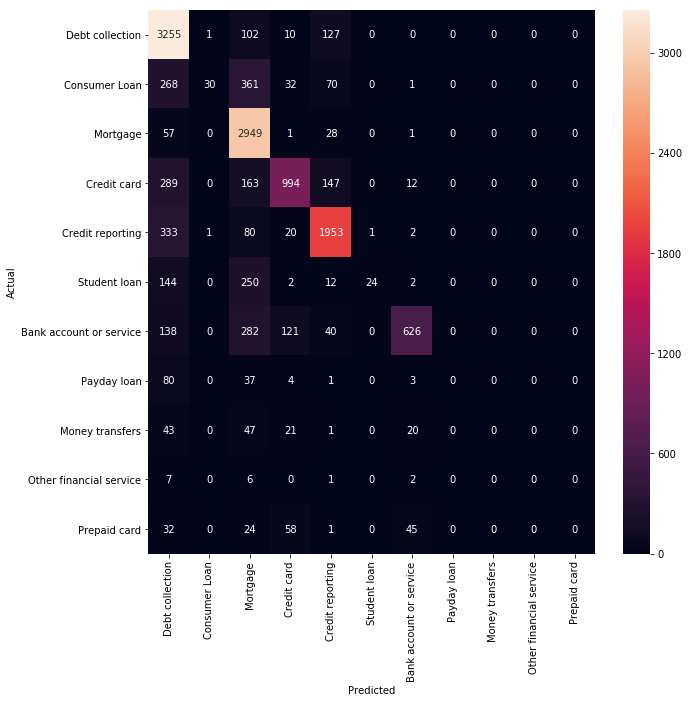

In [94]:
model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [95]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique(), digits=4))

                         precision    recall  f1-score   support

        Debt collection     0.7006    0.9313    0.7997      3495
          Consumer Loan     0.9375    0.0394    0.0756       762
               Mortgage     0.6857    0.9713    0.8039      3036
            Credit card     0.7870    0.6193    0.6932      1605
       Credit reporting     0.8202    0.8172    0.8187      2390
           Student loan     0.9600    0.0553    0.1046       434
Bank account or service     0.8768    0.5186    0.6517      1207
            Payday loan     0.0000    0.0000    0.0000       125
        Money transfers     0.0000    0.0000    0.0000       132
Other financial service     0.0000    0.0000    0.0000        16
           Prepaid card     0.0000    0.0000    0.0000       160

               accuracy                         0.7357     13362
              macro avg     0.5243    0.3593    0.3588     13362
           weighted avg     0.7441    0.7357    0.6881     13362



/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

# 3. Logistics Regression (default model uses OVR method)

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


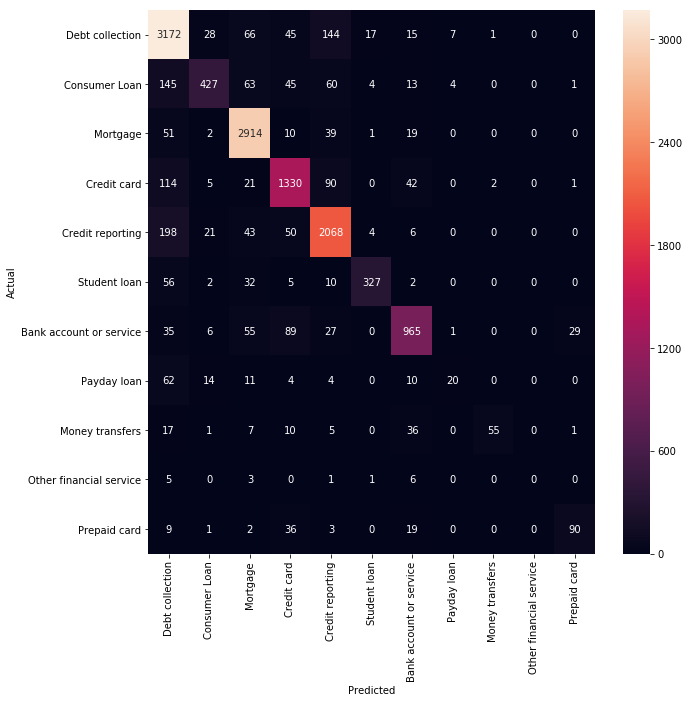

In [20]:
model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique(), digits=4))

                         precision    recall  f1-score   support

        Debt collection     0.8209    0.9076    0.8621      3495
          Consumer Loan     0.8422    0.5604    0.6730       762
               Mortgage     0.9058    0.9598    0.9320      3036
            Credit card     0.8190    0.8287    0.8238      1605
       Credit reporting     0.8437    0.8653    0.8544      2390
           Student loan     0.9237    0.7535    0.8299       434
Bank account or service     0.8517    0.7995    0.8248      1207
            Payday loan     0.6250    0.1600    0.2548       125
        Money transfers     0.9483    0.4167    0.5789       132
Other financial service     0.0000    0.0000    0.0000        16
           Prepaid card     0.7377    0.5625    0.6383       160

               accuracy                         0.8508     13362
              macro avg     0.7562    0.6194    0.6611     13362
           weighted avg     0.8488    0.8508    0.8446     13362



/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 3.5 Logistics Regression multi_class = ‘multinomial’

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


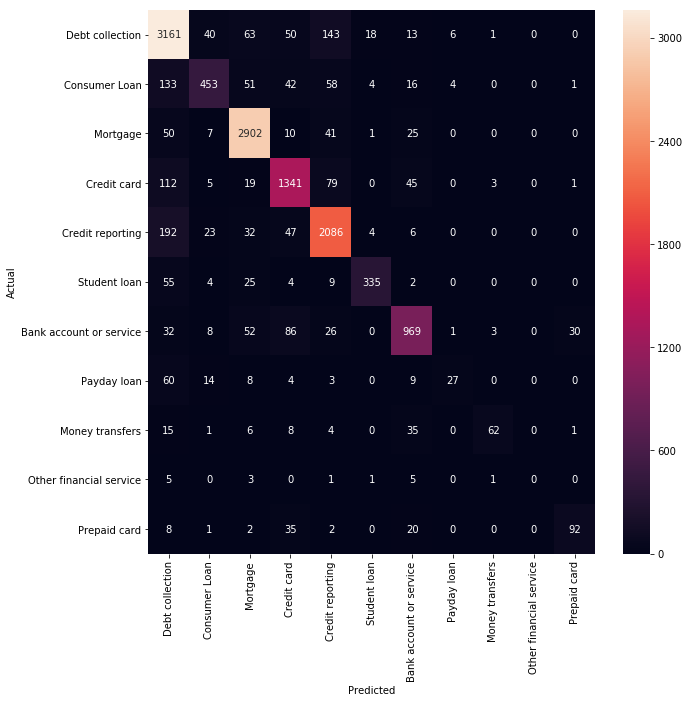

In [22]:
model = LogisticRegression(multi_class = "multinomial",solver = "lbfgs",random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique(), digits=4))

                         precision    recall  f1-score   support

        Debt collection     0.8268    0.9044    0.8639      3495
          Consumer Loan     0.8147    0.5945    0.6874       762
               Mortgage     0.9175    0.9559    0.9363      3036
            Credit card     0.8242    0.8355    0.8298      1605
       Credit reporting     0.8507    0.8728    0.8616      2390
           Student loan     0.9229    0.7719    0.8407       434
Bank account or service     0.8463    0.8028    0.8240      1207
            Payday loan     0.7105    0.2160    0.3313       125
        Money transfers     0.8857    0.4697    0.6139       132
Other financial service     0.0000    0.0000    0.0000        16
           Prepaid card     0.7360    0.5750    0.6456       160

               accuracy                         0.8553     13362
              macro avg     0.7578    0.6362    0.6759     13362
           weighted avg     0.8530    0.8553    0.8503     13362



/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4. Random Forest

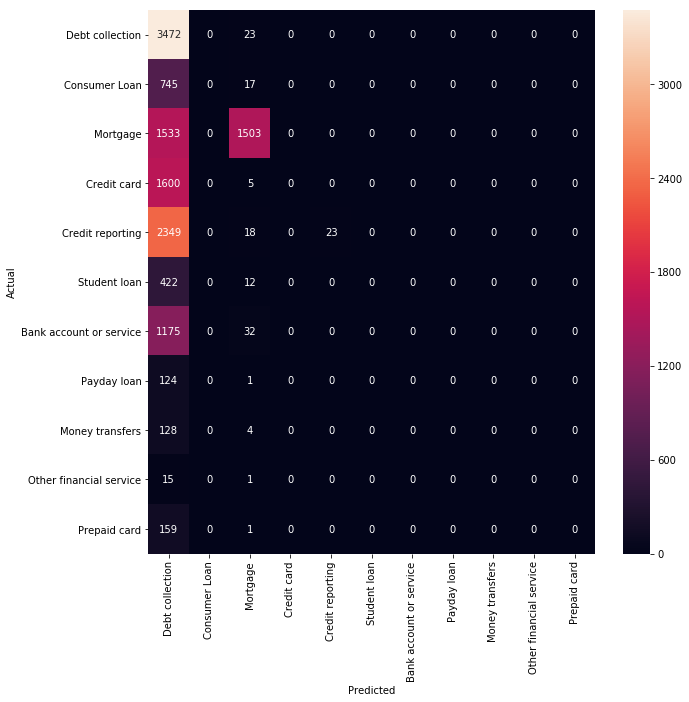

In [98]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [99]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['product'].unique(), digits=4))

                         precision    recall  f1-score   support

        Debt collection     0.2962    0.9934    0.4563      3495
          Consumer Loan     0.0000    0.0000    0.0000       762
               Mortgage     0.9295    0.4951    0.6460      3036
            Credit card     0.0000    0.0000    0.0000      1605
       Credit reporting     1.0000    0.0096    0.0191      2390
           Student loan     0.0000    0.0000    0.0000       434
Bank account or service     0.0000    0.0000    0.0000      1207
            Payday loan     0.0000    0.0000    0.0000       125
        Money transfers     0.0000    0.0000    0.0000       132
Other financial service     0.0000    0.0000    0.0000        16
           Prepaid card     0.0000    0.0000    0.0000       160

               accuracy                         0.3740     13362
              macro avg     0.2023    0.1362    0.1019     13362
           weighted avg     0.4675    0.3740    0.2696     13362



/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
